In [22]:
import os
from torchvision.datasets import ImageFolder
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import random_split, Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision import models
from torchvision.utils import make_grid
import optuna
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUROC, BinaryROC
from PIL import Image
import datetime

In [23]:
from cv2 import Laplacian
import cv2

In [24]:
data_dir = './data/train'

In [25]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)
sub_blur = os.listdir(data_dir + "/1")

['0', '1']
['0', '1']


In [26]:
def analyze_set(path):
  num = 0
  x = len(os.listdir(path))
  print(f"No. of classes: {x}")
  for new in classes:
    num += len(os.listdir(path + '/' + new))
  print(f"{path} SET CONTAINS {num} IMAGES")

In [27]:
dataset = ImageFolder(data_dir, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [28]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))

In [29]:
print(len(dataset))

1050


Label:  1 (1)
torch.Size([3, 2048, 1536])


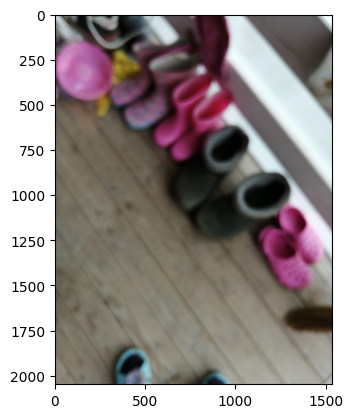

In [30]:
show_example(*dataset[650])

In [31]:
train_tfms_500 = tt.Compose([tt.Resize((500,500)),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(25),
                         tt.ToTensor()])
train_tfms_256 = tt.Compose([tt.Resize((256,256)),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(25),
                         tt.ToTensor()])
train_tfms_crop = tt.Compose([tt.Resize((1000, 1000)),
                              tt.RandomCrop(256),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(25),
                         tt.ToTensor()])

valid_tfms_256 = tt.Compose([tt.Resize((256,256)),
                         tt.ToTensor()])
valid_tfms_500 = tt.Compose([tt.Resize((500,500)),
                         tt.ToTensor()])
valid_tfms_1000 = tt.Compose([tt.Resize((1000, 1000)),
                              tt.ToTensor()])

In [32]:
train_dataset_256 = ImageFolder(data_dir, train_tfms_256)
train_dataset_500 = ImageFolder(data_dir, train_tfms_500)
train_dataset_crop = ImageFolder(data_dir, train_tfms_crop)

In [33]:
valid_dataset_1000 = ImageFolder(data_dir, valid_tfms_1000)
valid_dataset_256 = ImageFolder(data_dir, valid_tfms_256)
valid_dataset_500 = ImageFolder(data_dir, valid_tfms_500)

In [34]:
targets = dataset.targets

In [35]:
train_idx, valid_idx= train_test_split(
np.arange(len(targets)),
test_size=0.2,
shuffle=True,
stratify=targets)

In [36]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [37]:
to_image = tt.ToPILImage()

In [38]:
def show_batch(dl):
    for images, labels in dl:
        print(labels)
        fig, ax = plt.subplots(figsize=(16, 64))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:8], nrow=4).permute(1, 2, 0))
        
        break

In [39]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
device = get_default_device()
device

device(type='cuda')

In [54]:
accuracy = BinaryAccuracy().to(device)
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
f1score = BinaryF1Score().to(device)
auc_metric = BinaryAUROC().to(device)
roc = BinaryROC().to(device)

In [55]:
def metrics(preds, labels):
    acc = accuracy(preds, labels)
    prec = precision(preds, labels)
    rec = recall(preds, labels)
    return acc, prec, rec
class BaseModel(nn.Module):
    def training_step(self,batch):
        loss_func = torch.nn.BCELoss()
        images,labels = batch
        out = self(images).squeeze(1)
        labels = labels.to(torch.float32)
        loss = loss_func(torch.sigmoid(out),labels)
        acc, prec, rec = metrics(torch.sigmoid(out), labels)
        return loss, acc, prec, rec
    
    def validation_step(self,batch):
        images, labels = batch
        with torch.inference_mode():
            loss_func = torch.nn.BCELoss()
            out = self(images).squeeze(1)
            labels = labels.to(torch.float32)
            loss = loss_func(torch.sigmoid(out),labels)
        acc, rec, prec = metrics(torch.sigmoid(out), labels)
        return {"val_loss":loss.detach(),"val_acc":acc, "val_prec":prec, "val_rec":rec}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        batch_precision = [precision["val_prec"] for precision in outputs]
        prec = torch.stack(batch_precision).mean()
        batch_recall = [recall["val_rec"] for recall in outputs]
        rec = torch.stack(batch_recall).mean()
        f1 = 2 * (prec * rec) / (prec + rec)
        return {"val_loss":loss.item(),"val_acc":acc.item(), "val_prec": prec.item(), "val_rec": rec.item(), "val_f1": f1.item()}
    
    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch}], last_lr: {result["lrs"][-1]:.5f}, train_loss: {result["train_loss"]:.4f}, val_loss: {result["val_loss"]:.4f}, train_acc: {result["train_acc"]:.4f}, val_acc: {result["val_acc"]:.4f}')

In [56]:
class LaplacianModel(BaseModel):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold
    def process_image(self, image):
        fm = self.variance_of_laplacian(image)
        if fm < self.threshold:
            return 1
        else:
            return 0
    def variance_of_laplacian(self, image):
        return cv2.Laplacian(image, cv2.CV_64F).var()
    def forward(self, xb):
        out = self.process_image(xb)
        return out

In [57]:
class CustomModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
        self.model.fc = nn.Sequential(
          nn.Linear(512, 256),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, num_classes)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.fc.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        return out

In [58]:
def evaluate(model, test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [59]:
def roc_metric(model, dl, plot=False):
    y_all = np.array([])
    labels_all = np.array([])
    for batch in tqdm(dl):
        images, labels = batch
        out = model(images).squeeze(1)
        y_all = np.concatenate([y_all, torch.sigmoid(out).detach().cpu().numpy()])
        labels_all = np.concatenate([labels_all, labels.detach().cpu().numpy()])
    fpr,tpr, thresholds = roc(torch.Tensor(y_all), torch.Tensor(labels_all))
    auc = auc_metric(torch.Tensor(y_all), torch.Tensor(labels_all))
    if plot:
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    return auc

## First test: resize to 500

In [26]:
train_dl = DataLoader(train_dataset_500, batch_size=8, sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset_500, batch_size=8, sampler=valid_sampler, shuffle=False, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [27]:
lap_model = LaplacianModel(1000)

In [30]:
def testLaplacian(model, dl):
    labels = []
    results = []
    for data in tqdm(dl):
        images, targets = data
        for image in images:
            image = to_image(image)
            image = np.asarray(image)
            result = model(image)
            results.append(result)
        for label in targets:
            labels.append(label)
    acc, prec, rec = metrics(torch.Tensor(results), torch.Tensor(labels))
    f1 = 2 * (rec * prec) / (rec + prec)
    print(f'acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}')

In [31]:
testLaplacian(lap_model, train_dl)
testLaplacian(lap_model, valid_dl)

  0%|          | 0/105 [00:00<?, ?it/s]

acc: 0.7417, prec: 0.7242, rec: 0.9893, f1: 0.8362


  0%|          | 0/27 [00:00<?, ?it/s]

acc: 0.7095, prec: 0.6965, rec: 1.0000, f1: 0.8211


In [52]:
model = CustomModel(1).to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


147841

In [53]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [54]:
writer.add_graph(model, images)
writer.close()

In [55]:
epochs = 15

In [57]:
max_lr = 0.0001
weight_decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
grad_clip = 1
torch.cuda.empty_cache()
scheduler = torch.optim.lr_scheduler.OneCycleLR
scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=int(len(train_dl)))
#history_500 = []
for epoch in range(epochs):
    model.train()

    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    lrs = []
    for batch in tqdm(train_dl, f'training {epoch+1} epoch:'):
        loss, batch_acc, batch_prec, batch_rec = model.training_step(batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss)
        train_acc.append(batch_acc)
        train_prec.append(batch_prec)
        train_rec.append(batch_rec)
        lrs.append(get_lr(optimizer))
        scheduler.step()
        del batch
        torch.cuda.empty_cache()
    result = evaluate(model, valid_dl)
    result["train_loss"] = torch.stack(train_loss).mean().item()
    result["lrs"] = lrs
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_prec"] = torch.stack(train_prec).mean().item()
    result["train_rec"] = torch.stack(train_rec).mean().item()
    result["train_f1"] = 2 * (result["train_rec"] * result["train_prec"]) / (result["train_rec"] + result["train_prec"])
    result["train_auc"] = roc_metric(model, train_dl)
    result["valid_auc"] = roc_metric(model, valid_dl)
    history_500.append(result)
    model.epoch_end(epoch,result)

training 1 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00002, train_loss: 0.1963, val_loss: 0.2833, train_acc: 0.9286, val_acc: 0.8889


training 2 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00004, train_loss: 0.1953, val_loss: 0.2605, train_acc: 0.9345, val_acc: 0.9028


training 3 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00008, train_loss: 0.2052, val_loss: 0.2457, train_acc: 0.9250, val_acc: 0.9167


training 4 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00010, train_loss: 0.1830, val_loss: 0.2644, train_acc: 0.9310, val_acc: 0.9028


training 5 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00010, train_loss: 0.2098, val_loss: 0.2555, train_acc: 0.9190, val_acc: 0.9028


training 6 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00010, train_loss: 0.1792, val_loss: 0.2828, train_acc: 0.9274, val_acc: 0.8889


training 7 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00009, train_loss: 0.2357, val_loss: 0.2329, train_acc: 0.9012, val_acc: 0.9028


training 8 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00008, train_loss: 0.1868, val_loss: 0.2434, train_acc: 0.9214, val_acc: 0.9074


training 9 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00006, train_loss: 0.1733, val_loss: 0.3410, train_acc: 0.9238, val_acc: 0.8519


training 10 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00005, train_loss: 0.1736, val_loss: 0.2470, train_acc: 0.9286, val_acc: 0.9074


training 11 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00003, train_loss: 0.1539, val_loss: 0.2332, train_acc: 0.9440, val_acc: 0.9213


training 12 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00002, train_loss: 0.1721, val_loss: 0.2092, train_acc: 0.9298, val_acc: 0.9306


training 13 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00001, train_loss: 0.1728, val_loss: 0.1938, train_acc: 0.9262, val_acc: 0.9398


training 14 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00000, train_loss: 0.1592, val_loss: 0.2577, train_acc: 0.9393, val_acc: 0.8889


training 15 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00000, train_loss: 0.1305, val_loss: 0.2277, train_acc: 0.9548, val_acc: 0.9120


In [58]:
for result in history_500:
    print(result["train_acc"])

0.6642857193946838
0.6666666865348816
0.6678571701049805
0.7142857313156128
0.8142857551574707
0.8738095760345459
0.8940476775169373
0.8976190686225891
0.9000000357627869
0.9178571701049805
0.9035714864730835
0.9273809790611267
0.9309524297714233
0.9130952954292297
0.9214286208152771
0.9285714626312256
0.9345238208770752
0.925000011920929
0.9309524297714233
0.9190476536750793
0.9273809790611267
0.9011905193328857
0.9214286208152771
0.9238095879554749
0.9285714626312256
0.9440476298332214
0.9297619462013245
0.9261904954910278
0.9392857551574707
0.9547619223594666


In [59]:
for result in history_500:
    print(result["val_acc"])

0.6620370149612427
0.6759259104728699
0.6620370149612427
0.7870370149612427
0.7916666865348816
0.8472222089767456
0.9074074029922485
0.8240740895271301
0.8842592835426331
0.8842592835426331
0.8518518805503845
0.8888888955116272
0.8981481790542603
0.8981481790542603
0.8888888955116272
0.8888888955116272
0.9027777910232544
0.9166666865348816
0.9027777910232544
0.9027777910232544
0.8888888955116272
0.9027777910232544
0.9074074029922485
0.8518518805503845
0.9074074029922485
0.9212962985038757
0.9305555820465088
0.9398148059844971
0.8888888955116272
0.9120370149612427


In [60]:
for result in history_500:
    print(result["train_prec"])

0.6658163666725159
0.6666666865348816
0.6676871180534363
0.7093084454536438
0.8124603629112244
0.870022714138031
0.9059977531433105
0.906848132610321
0.9149886965751648
0.9338775873184204
0.9282313585281372
0.9428344964981079
0.9317687153816223
0.9135828018188477
0.926893413066864
0.9441950917243958
0.941111147403717
0.9376643896102905
0.9380952715873718
0.9378117322921753
0.9487075209617615
0.922120213508606
0.9443537592887878
0.9350340962409973
0.942539632320404
0.9512698650360107
0.9449886679649353
0.9497506618499756
0.963219940662384
0.9678458571434021


In [61]:
for result in history_500:
    print(result["val_prec"])

1.0
1.0
1.0
0.9947090148925781
0.9925925731658936
0.8148148059844971
0.9576719999313354
0.7734568119049072
0.9055556058883667
0.872927725315094
0.8019841313362122
0.8867283463478088
0.9038360118865967
0.9140652418136597
0.8665785193443298
0.8817461133003235
0.908950686454773
0.9302469491958618
0.9041445851325989
0.8974426984786987
0.8636684417724609
0.9000881314277649
0.8928571939468384
0.8006613850593567
0.8860670328140259
0.9283068776130676
0.8993827104568481
0.9612874984741211
0.8380070328712463
0.9236331582069397


In [62]:
for result in history_500:
    print(result["train_rec"])

0.996258556842804
1.0
1.0
0.9937301874160767
0.969036340713501
0.9750113487243652
0.9512925148010254
0.9545125961303711
0.9502267837524414
0.9584920406341553
0.9448299407958984
0.9596598744392395
0.9730272889137268
0.9640136361122131
0.9662925601005554
0.9556236267089844
0.9675624966621399
0.959229052066803
0.9649320244789124
0.9500907063484192
0.9556803107261658
0.9452721476554871
0.9462131857872009
0.9586621522903442
0.957551121711731
0.9686394333839417
0.9579251408576965
0.9564853310585022
0.9552268385887146
0.970430850982666


In [63]:
for result in history_500:
    print(result["val_rec"])

0.6620370149612427
0.6759259104728699
0.6620370149612427
0.7690476179122925
0.7556878328323364
0.9370369911193848
0.9109787940979004
0.9555555582046509
0.8812610507011414
0.9292769432067871
0.9255732297897339
0.9400352239608765
0.9353615045547485
0.9388888478279114
0.9360670447349548
0.9305555820465088
0.9327160120010376
0.9478395581245422
0.9447090029716492
0.9434744119644165
0.9648147821426392
0.9647266268730164
0.9638447761535645
0.9360670447349548
0.9574074149131775
0.9586420059204102
0.9188271760940552
0.9545855522155762
0.933950662612915
0.950529158115387


In [64]:
for result in history_500:
    print(result["train_f1"])

0.7981893513928174
0.8000000143051146
0.8007342754230499
0.8277689076832306
0.8838676102497043
0.9195299284789625
0.9280928198107687
0.9300700847379313
0.9322748770707692
0.9460247312675286
0.9364571035016762
0.9511727848956191
0.9519511643009798
0.9381209517434197
0.9461830181999948
0.9498749845127705
0.9541535340518306
0.9483241428759037
0.9513244202413889
0.9439112879126175
0.9521811506402877
0.933552661719624
0.9452825581385038
0.9467007180929269
0.9499860785816986
0.9598760772938858
0.9514129317599722
0.9531060997715833
0.959206738217376
0.9691366303171104


In [65]:
for result in history_500:
    print(result["val_f1"])

0.796657383441925
0.8066297769546509
0.796657383441925
0.8674423098564148
0.858089029788971
0.8716623187065125
0.9337420463562012
0.8549169301986694
0.8932432532310486
0.9002214670181274
0.8593578338623047
0.9126039743423462
0.9193285703659058
0.9263107776641846
0.8999834656715393
0.9054936170578003
0.920680046081543
0.9389607906341553
0.923981785774231
0.9198830127716064
0.9114440679550171
0.9312871694564819
0.9269939661026001
0.8630856871604919
0.9203568696975708
0.9432306289672852
0.9090009927749634
0.9579247832298279
0.8833814263343811
0.9368881583213806


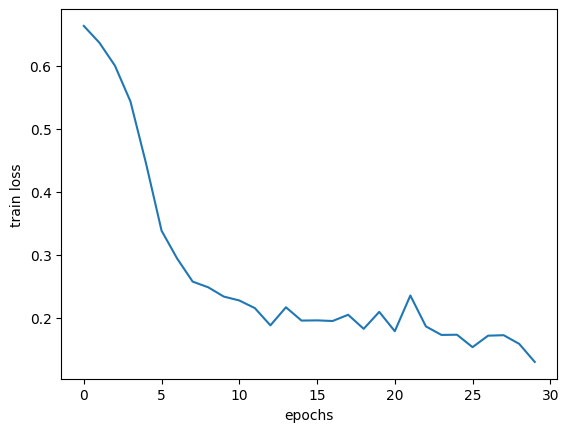

In [197]:
train_losses = []
for result in history_500:
    train_losses.append(result["train_loss"])
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.show()

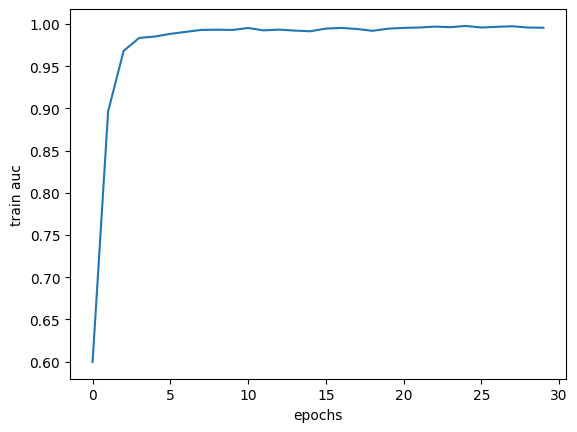

In [196]:
train_auc = []
for result in history_500:
    train_auc.append(result["train_auc"])
plt.plot(train_auc)
plt.ylabel('train auc')
plt.xlabel('epochs')
plt.show()

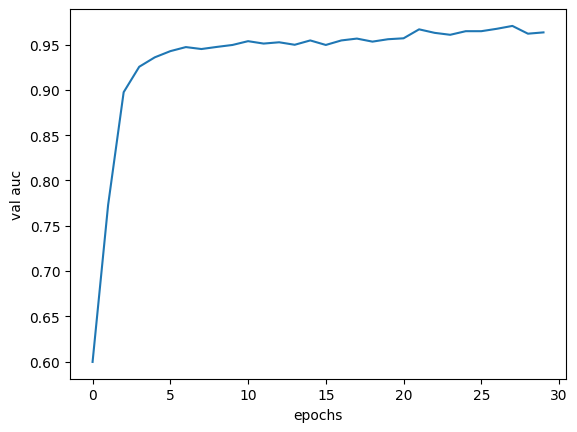

In [195]:
val_auc = []
for result in history_500:
    val_auc.append(result["valid_auc"])
plt.plot(val_auc)
plt.ylabel('val auc')
plt.xlabel('epochs')
plt.show()

## Resizing to 256

In [70]:
train_dl = DataLoader(train_dataset_256, batch_size=16, sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset_256, batch_size=16, sampler=valid_sampler, shuffle=False, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [71]:
lap_model = LaplacianModel(1000)

In [72]:
def testLaplacian(model, dl):
    labels = []
    results = []
    for data in tqdm(dl):
        images, targets = data
        for image in images:
            image = to_image(image)
            image = np.asarray(image)
            result = model(image)
            results.append(result)
        for label in targets:
            labels.append(label)
    acc, prec, rec = metrics(torch.Tensor(results), torch.Tensor(labels))
    f1 = 2 * (rec * prec) / (rec + prec)
    print(f'acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}')

In [73]:
testLaplacian(lap_model, train_dl)
testLaplacian(lap_model, valid_dl)

  0%|          | 0/53 [00:00<?, ?it/s]

acc: 0.7655, prec: 0.8135, rec: 0.8411, f1: 0.8270


  0%|          | 0/14 [00:00<?, ?it/s]

acc: 0.7476, prec: 0.7254, rec: 1.0000, f1: 0.8408


In [74]:
model = CustomModel(1).to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


147841

In [75]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [76]:
writer.add_graph(model, images)
writer.close()

In [78]:
epochs = 30

In [79]:
max_lr = 0.0001
weight_decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
grad_clip = 1
torch.cuda.empty_cache()
scheduler = torch.optim.lr_scheduler.OneCycleLR
scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=int(len(train_dl)))
history_256 = []
for epoch in range(epochs):
    model.train()

    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    lrs = []
    for batch in tqdm(train_dl, f'training {epoch+1} epoch:'):
        loss, batch_acc, batch_prec, batch_rec = model.training_step(batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss)
        train_acc.append(batch_acc)
        train_prec.append(batch_prec)
        train_rec.append(batch_rec)
        lrs.append(get_lr(optimizer))
        scheduler.step()
        del batch
        torch.cuda.empty_cache()
    result = evaluate(model, valid_dl)
    result["train_loss"] = torch.stack(train_loss).mean().item()
    result["lrs"] = lrs
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_prec"] = torch.stack(train_prec).mean().item()
    result["train_rec"] = torch.stack(train_rec).mean().item()
    result["train_f1"] = 2 * (result["train_rec"] * result["train_prec"]) / (result["train_rec"] + result["train_prec"])
    result["train_auc"] = roc_metric(model, train_dl)
    result["valid_auc"] = roc_metric(model, valid_dl)
    history_256.append(result)
    model.epoch_end(epoch,result)

training 1 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00001, train_loss: 0.6935, val_loss: 0.6886, train_acc: 0.5047, val_acc: 0.5670


training 2 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00002, train_loss: 0.6715, val_loss: 0.6619, train_acc: 0.6462, val_acc: 0.6875


training 3 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00003, train_loss: 0.6513, val_loss: 0.6449, train_acc: 0.6651, val_acc: 0.6875


training 4 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00004, train_loss: 0.6367, val_loss: 0.6331, train_acc: 0.6663, val_acc: 0.6875


training 5 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00006, train_loss: 0.6275, val_loss: 0.6272, train_acc: 0.6639, val_acc: 0.6875


training 6 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00008, train_loss: 0.6079, val_loss: 0.6265, train_acc: 0.6663, val_acc: 0.6562


training 7 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00009, train_loss: 0.5822, val_loss: 0.6251, train_acc: 0.6899, val_acc: 0.6830


training 8 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00010, train_loss: 0.5366, val_loss: 0.5829, train_acc: 0.7323, val_acc: 0.7768


training 9 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00010, train_loss: 0.5003, val_loss: 0.5777, train_acc: 0.7724, val_acc: 0.7455


training 10 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00010, train_loss: 0.4202, val_loss: 0.5533, train_acc: 0.8290, val_acc: 0.7634


training 11 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00010, train_loss: 0.4222, val_loss: 0.5612, train_acc: 0.8113, val_acc: 0.7277


training 12 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00010, train_loss: 0.3812, val_loss: 0.4755, train_acc: 0.8432, val_acc: 0.7902


training 13 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00009, train_loss: 0.3527, val_loss: 0.5799, train_acc: 0.8561, val_acc: 0.6696


training 14 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00009, train_loss: 0.3316, val_loss: 0.5587, train_acc: 0.8620, val_acc: 0.7232


training 15 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00008, train_loss: 0.3409, val_loss: 0.5941, train_acc: 0.8420, val_acc: 0.6875


training 16 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00008, train_loss: 0.3181, val_loss: 0.5679, train_acc: 0.8550, val_acc: 0.7411


training 17 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00007, train_loss: 0.3241, val_loss: 0.4484, train_acc: 0.8538, val_acc: 0.8036


training 18 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00006, train_loss: 0.2935, val_loss: 0.5107, train_acc: 0.8679, val_acc: 0.7500


training 19 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.3086, val_loss: 0.4885, train_acc: 0.8679, val_acc: 0.7723


training 20 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00005, train_loss: 0.2943, val_loss: 0.5368, train_acc: 0.8691, val_acc: 0.7679


training 21 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00004, train_loss: 0.2778, val_loss: 0.4639, train_acc: 0.8868, val_acc: 0.7857


training 22 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00003, train_loss: 0.2735, val_loss: 0.4516, train_acc: 0.8856, val_acc: 0.8036


training 23 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00003, train_loss: 0.2949, val_loss: 0.4578, train_acc: 0.8785, val_acc: 0.7902


training 24 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00002, train_loss: 0.2849, val_loss: 0.4627, train_acc: 0.8738, val_acc: 0.7902


training 25 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00001, train_loss: 0.2524, val_loss: 0.5208, train_acc: 0.9021, val_acc: 0.7768


training 26 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00001, train_loss: 0.2733, val_loss: 0.4482, train_acc: 0.8809, val_acc: 0.8036


training 27 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00000, train_loss: 0.2726, val_loss: 0.4742, train_acc: 0.8903, val_acc: 0.7857


training 28 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00000, train_loss: 0.2932, val_loss: 0.4567, train_acc: 0.8573, val_acc: 0.7768


training 29 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00000, train_loss: 0.2955, val_loss: 0.4641, train_acc: 0.8667, val_acc: 0.8080


training 30 epoch::   0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00000, train_loss: 0.2871, val_loss: 0.4915, train_acc: 0.8892, val_acc: 0.7679


In [80]:
for result in history_256:
    print(result["train_acc"])

0.5047169923782349
0.6462264060974121
0.6650943756103516
0.6662735939025879
0.6639150977134705
0.6662735939025879
0.6898584961891174
0.7323113083839417
0.7724056839942932
0.829009473323822
0.8113207817077637
0.8431603908538818
0.8561320900917053
0.8620283007621765
0.8419811725616455
0.854952871799469
0.8537735939025879
0.8679245710372925
0.8679245710372925
0.8691037893295288
0.8867924809455872
0.885613203048706
0.8785377740859985
0.8738207817077637
0.9021226763725281
0.8808962106704712
0.8903301954269409
0.8573113083839417
0.8667452931404114
0.8891509771347046


In [81]:
for result in history_256:
    print(result["val_acc"])

0.566964328289032
0.6875000596046448
0.6875000596046448
0.6875000596046448
0.6875000596046448
0.65625
0.6830357313156128
0.7767857313156128
0.7455357313156128
0.7633928656578064
0.7276785969734192
0.7901785969734192
0.6696428656578064
0.723214328289032
0.6875000596046448
0.7410714626312256
0.8035714626312256
0.7500000596046448
0.7723214626312256
0.7678571939468384
0.785714328289032
0.8035714626312256
0.7901785969734192
0.7901785969734192
0.7767857313156128
0.8035714626312256
0.785714328289032
0.7767857313156128
0.8080357313156128
0.7678571939468384


In [82]:
for result in history_256:
    print(result["train_prec"])

0.6551491022109985
0.680169403553009
0.6668239235877991
0.6662735939025879
0.6639150977134705
0.6665094494819641
0.6883319616317749
0.7270683646202087
0.7809233665466309
0.8405584692955017
0.837334394454956
0.8639397621154785
0.8715538382530212
0.8840522170066833
0.8819451928138733
0.8771271705627441
0.8869171738624573
0.8909019231796265
0.9183035492897034
0.8791829943656921
0.9095923900604248
0.9045194387435913
0.9072965383529663
0.8969667553901672
0.9152343273162842
0.9142366647720337
0.9127868413925171
0.8873149156570435
0.89112389087677
0.9088687896728516


In [83]:
for result in history_256:
    print(result["val_prec"])

0.8012662529945374
1.0
1.0
1.0
1.0
1.0
0.9158028364181519
0.8312051296234131
0.7846372127532959
0.8329539895057678
0.6480727195739746
0.887723445892334
0.5431616306304932
0.709689199924469
0.6042291522026062
0.7149299383163452
0.8372655510902405
0.7348547577857971
0.7401140928268433
0.7934033870697021
0.7641573548316956
0.8232349157333374
0.8313769698143005
0.6723368167877197
0.7346709370613098
0.7873955368995667
0.7546913623809814
0.7385745644569397
0.8039683103561401
0.6601523756980896


In [84]:
for result in history_256:
    print(result["train_rec"])

0.5127366185188293
0.8806247711181641
0.9930062294006348
1.0
1.0
0.9973046183586121
0.989997923374176
0.9787533283233643
0.9415554404258728
0.9260583519935608
0.9132242202758789
0.9195812940597534
0.9366701245307922
0.918792724609375
0.8931229710578918
0.923522412776947
0.9057218432426453
0.9302444458007812
0.8987881541252136
0.9386952519416809
0.9278279542922974
0.9361220002174377
0.9224324822425842
0.9262575507164001
0.9457260370254517
0.9146876335144043
0.9293630719184875
0.9188158512115479
0.9219842553138733
0.9362208843231201


In [85]:
for result in history_256:
    print(result["val_rec"])

0.618645966053009
0.6875000596046448
0.6875000596046448
0.6875000596046448
0.6875000596046448
0.65625
0.7016462683677673
0.8400710821151733
0.8434703946113586
0.8265687227249146
0.8329082727432251
0.8107912540435791
0.8372448682785034
0.880122721195221
0.9170610308647156
0.8958798050880432
0.8894712924957275
0.8941250443458557
0.8243867754936218
0.8701087236404419
0.900284469127655
0.8907467722892761
0.8638812303543091
0.8169758915901184
0.920351505279541
0.9035894870758057
0.8923160433769226
0.8407467603683472
0.8992754220962524
0.8358766436576843


In [86]:
for result in history_256:
    print(result["train_f1"])

0.5752599408157743
0.7675246807627766
0.7978651416156933
0.7997169208474403
0.7980155942160914
0.7990231180227171
0.812053957562835
0.8343434542243149
0.8537494236228427
0.8812394192669761
0.8736343279815036
0.8908925876541721
0.902939524100698
0.9010877490467082
0.887498888153183
0.8997270855642183
0.8962208786591026
0.9101482230174304
0.9084410549468683
0.907964990587607
0.9186196823208752
0.92004942223854
0.9148019062742146
0.9113768691422559
0.9302303798701841
0.9144620935441965
0.9210003776496177
0.902790677704508
0.9062914406386776
0.9223420996751605


In [87]:
for result in history_256:
    print(result["val_f1"])

0.6982123255729675
0.8148148655891418
0.8148148655891418
0.8148148655891418
0.8148148655891418
0.7924528121948242
0.7945470213890076
0.8356145620346069
0.8129908442497253
0.8297490477561951
0.7289562225341797
0.8475150465965271
0.6588773727416992
0.7857704162597656
0.728480339050293
0.7952413558959961
0.8625792860984802
0.8067037463188171
0.7799807786941528
0.8299875855445862
0.826654314994812
0.8556612730026245
0.8473175168037415
0.7376328706741333
0.8170952796936035
0.8415005207061768
0.8177537322044373
0.7863556742668152
0.8489553928375244
0.7376942038536072


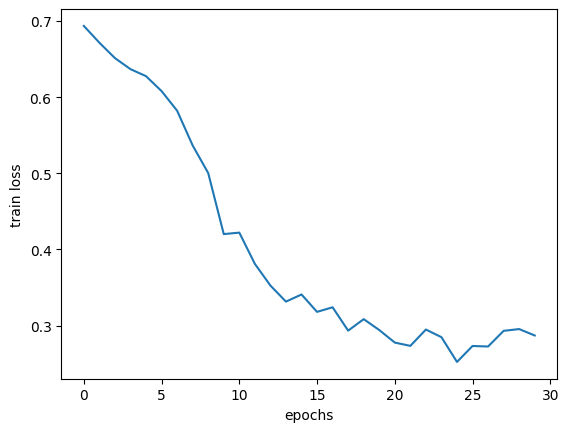

In [194]:
train_losses = []
for result in history_256:
    train_losses.append(result["train_loss"])
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.show()

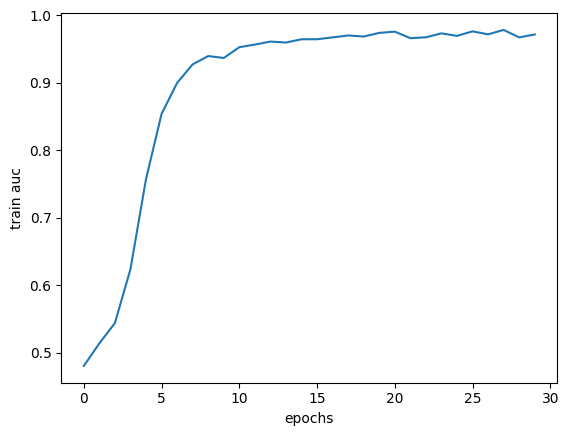

In [193]:
train_auc = []
for result in history_256:
    train_auc.append(result["train_auc"])
plt.plot(train_auc)
plt.ylabel('train auc')
plt.xlabel('epochs')
plt.show()

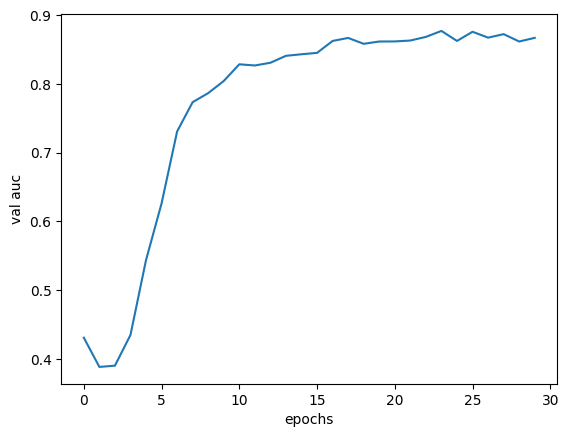

In [192]:
val_auc = []
for result in history_256:
    val_auc.append(result["valid_auc"])
plt.plot(val_auc)
plt.ylabel('val auc')
plt.xlabel('epochs')
plt.show()

## Random crop 256 from the whole image

In [103]:
train_dl = DataLoader(train_dataset_crop, batch_size=8, sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset_1000, batch_size=8, sampler=valid_sampler, shuffle=False, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [104]:
lap_model = LaplacianModel(1000)

In [105]:
def testLaplacian(model, dl):
    labels = []
    results = []
    for data in tqdm(dl):
        images, targets = data
        for image in images:
            image = to_image(image)
            image = np.asarray(image)
            result = model(image)
            results.append(result)
        for label in targets:
            labels.append(label)
    acc, prec, rec = metrics(torch.Tensor(results), torch.Tensor(labels))
    f1 = 2 * (rec * prec) / (rec + prec)
    print(f'acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}')

In [106]:
testLaplacian(lap_model, train_dl)
testLaplacian(lap_model, valid_dl)

  0%|          | 0/105 [00:00<?, ?it/s]

acc: 0.7262, prec: 0.7292, rec: 0.9375, f1: 0.8203


  0%|          | 0/27 [00:00<?, ?it/s]

acc: 0.6905, prec: 0.6847, rec: 0.9929, f1: 0.8105


In [107]:
model = CustomModel(1).to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


147841

In [108]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [109]:
writer.add_graph(model, images)
writer.close()

In [110]:
epochs = 30

In [112]:
max_lr = 0.0001
weight_decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
grad_clip = 1
torch.cuda.empty_cache()
scheduler = torch.optim.lr_scheduler.OneCycleLR
scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=int(len(train_dl)))
#history_crop = []
for epoch in range(epochs):
    model.train()

    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    lrs = []
    for batch in tqdm(train_dl, f'training {epoch+1} epoch:'):
        loss, batch_acc, batch_prec, batch_rec = model.training_step(batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss)
        train_acc.append(batch_acc)
        train_prec.append(batch_prec)
        train_rec.append(batch_rec)
        lrs.append(get_lr(optimizer))
        scheduler.step()
        del batch
        torch.cuda.empty_cache()
    result = evaluate(model, valid_dl)
    result["train_loss"] = torch.stack(train_loss).mean().item()
    result["lrs"] = lrs
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_prec"] = torch.stack(train_prec).mean().item()
    result["train_rec"] = torch.stack(train_rec).mean().item()
    result["train_f1"] = 2 * (result["train_rec"] * result["train_prec"]) / (result["train_rec"] + result["train_prec"])
    result["train_auc"] = roc_metric(model, train_dl)
    result["valid_auc"] = roc_metric(model, valid_dl)
    history_crop.append(result)
    model.epoch_end(epoch,result)

training 1 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00002, train_loss: 0.3004, val_loss: 0.2748, train_acc: 0.8690, val_acc: 0.9398


training 2 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00004, train_loss: 0.3315, val_loss: 0.2705, train_acc: 0.8667, val_acc: 0.9398


training 3 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00008, train_loss: 0.3194, val_loss: 0.2752, train_acc: 0.8595, val_acc: 0.9259


training 4 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00010, train_loss: 0.3180, val_loss: 0.2625, train_acc: 0.8690, val_acc: 0.9306


training 5 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00010, train_loss: 0.3258, val_loss: 0.2635, train_acc: 0.8548, val_acc: 0.9398


training 6 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00010, train_loss: 0.2806, val_loss: 0.2611, train_acc: 0.8738, val_acc: 0.9074


training 7 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00009, train_loss: 0.2938, val_loss: 0.2190, train_acc: 0.8845, val_acc: 0.9398


training 8 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00008, train_loss: 0.3077, val_loss: 0.2319, train_acc: 0.8881, val_acc: 0.9491


training 9 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00006, train_loss: 0.2838, val_loss: 0.2447, train_acc: 0.8976, val_acc: 0.9074


training 10 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00005, train_loss: 0.3030, val_loss: 0.2180, train_acc: 0.8810, val_acc: 0.9444


training 11 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00003, train_loss: 0.2871, val_loss: 0.2276, train_acc: 0.8810, val_acc: 0.9213


training 12 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00002, train_loss: 0.3099, val_loss: 0.2240, train_acc: 0.8726, val_acc: 0.9352


training 13 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00001, train_loss: 0.2907, val_loss: 0.2266, train_acc: 0.8881, val_acc: 0.9259


training 14 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00000, train_loss: 0.2481, val_loss: 0.2111, train_acc: 0.9071, val_acc: 0.9491


training 15 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00000, train_loss: 0.2839, val_loss: 0.2166, train_acc: 0.8929, val_acc: 0.9398


In [113]:
for result in history_crop:
    print(result["train_acc"])

0.3702380955219269
0.6595238447189331
0.6726190447807312
0.7261905074119568
0.8202381134033203
0.8309524059295654
0.8500000238418579
0.8333333730697632
0.860714316368103
0.8476190567016602
0.872619092464447
0.8690476417541504
0.8738095760345459
0.8761904835700989
0.884523868560791
0.8690476417541504
0.8666666746139526
0.8595238327980042
0.8690476417541504
0.8547619581222534
0.8738095760345459
0.884523868560791
0.8880952596664429
0.8976190686225891
0.8809524178504944
0.8809524178504944
0.872619092464447
0.8880952596664429
0.9071428775787354
0.8928571939468384


In [114]:
for result in history_crop:
    print(result["val_acc"])

0.5046296119689941
0.6620370149612427
0.6481481790542603
0.8472222089767456
0.8888888955116272
0.8657407760620117
0.9074074029922485
0.9166666865348816
0.8981481790542603
0.9305555820465088
0.9398148059844971
0.9305555820465088
0.9305555820465088
0.9398148059844971
0.9259259104728699
0.9398148059844971
0.9398148059844971
0.9259259104728699
0.9305555820465088
0.9398148059844971
0.9074074029922485
0.9398148059844971
0.9490740895271301
0.9074074029922485
0.944444477558136
0.9212962985038757
0.9351851940155029
0.9259259104728699
0.9490740895271301
0.9398148059844971


In [115]:
for result in history_crop:
    print(result["train_prec"])

0.3107936680316925
0.705566942691803
0.6736395359039307
0.7312018275260925
0.8240929841995239
0.8451587557792664
0.8695124387741089
0.8673242926597595
0.8797052502632141
0.8724263906478882
0.8851247429847717
0.8975510597229004
0.8877097368240356
0.8851927518844604
0.9020861983299255
0.8856009244918823
0.8866439461708069
0.8790249228477478
0.8854422569274902
0.8820408582687378
0.8914059400558472
0.8943310379981995
0.898560106754303
0.9127664566040039
0.8922675848007202
0.9024943113327026
0.8854195475578308
0.8963492512702942
0.9147846102714539
0.9133560061454773


In [116]:
for result in history_crop:
    print(result["val_prec"])

0.3305114805698395
1.0
0.9629629850387573
0.868562638759613
0.9107584357261658
0.9802469611167908
0.9470899701118469
0.9169312119483948
0.9833332896232605
0.9455908536911011
0.970634937286377
0.9388447403907776
0.9496913552284241
0.9685185551643372
0.9581129550933838
0.9412698745727539
0.9437389969825745
0.944444477558136
0.9542328119277954
0.9262345433235168
0.9555555582046509
0.9770723581314087
0.9348323941230774
0.9833332896232605
0.9718694686889648
0.9749559760093689
0.950925886631012
0.9864197373390198
0.9728394746780396
0.9687830805778503


In [117]:
for result in history_crop:
    print(result["train_rec"])

0.10117914527654648
0.8732313513755798
0.9972789883613586
0.9687415361404419
0.9566439986228943
0.9405555725097656
0.9249206781387329
0.9169954657554626
0.9298866391181946
0.9233446717262268
0.9378572106361389
0.9259297847747803
0.9410771131515503
0.9528799057006836
0.938718855381012
0.9364172220230103
0.9388549327850342
0.9256689548492432
0.9432086944580078
0.9180386066436768
0.9407029151916504
0.951201856136322
0.9549773335456848
0.9411337971687317
0.9449319243431091
0.9388095140457153
0.9409410953521729
0.9553515315055847
0.9565193057060242
0.9414512515068054


In [118]:
for result in history_crop:
    print(result["val_rec"])

0.7858024835586548
0.6620370149612427
0.6481481790542603
0.9072310924530029
0.9138447642326355
0.8447089791297913
0.9345238208770752
0.9700176119804382
0.8722222447395325
0.9521163702011108
0.9428572058677673
0.9530864357948303
0.946208119392395
0.9416225552558899
0.9313932657241821
0.9684303402900696
0.9511463642120361
0.9495590925216675
0.9469135403633118
0.9845678806304932
0.8632274866104126
0.9409171342849731
0.9814814925193787
0.882583737373352
0.9438271522521973
0.9073192477226257
0.9471781849861145
0.9109787940979004
0.9490299820899963
0.9446649551391602


In [119]:
for result in history_crop:
    print(result["train_f1"])

0.1526597710965045
0.7804963777423531
0.8041164726232042
0.8333755074034059
0.8854352049140598
0.8903090094654212
0.8963611147621
0.891468516175546
0.9041001602427878
0.8971636487037344
0.9107282942345035
0.9115195940350425
0.9136147457075585
0.9177900367124319
0.9200380255847022
0.9103004370400433
0.91200279779146
0.9017441591338181
0.9134130650157856
0.8996797933775932
0.915391205089078
0.9218901988123587
0.9259101177258866
0.9267330963290124
0.9178449283688724
0.9202937985284957
0.9123363911279204
0.9249103720539991
0.9351865646370379
0.9271908458513453


In [120]:
for result in history_crop:
    print(result["val_f1"])

0.46531131863594055
0.796657383441925
0.774797797203064
0.887475848197937
0.9122989773750305
0.9074448347091675
0.9407649636268616
0.9427276253700256
0.9244510531425476
0.9488424062728882
0.9565443992614746
0.9459120035171509
0.9479464888572693
0.9548811912536621
0.944564163684845
0.9546569585800171
0.9474282264709473
0.9469948410987854
0.9505590200424194
0.9545108079910278
0.9070480465888977
0.95865398645401
0.9575891494750977
0.9302385449409485
0.9576430916786194
0.9399224519729614
0.9490483403205872
0.9471995830535889
0.9607872366905212
0.9565719962120056


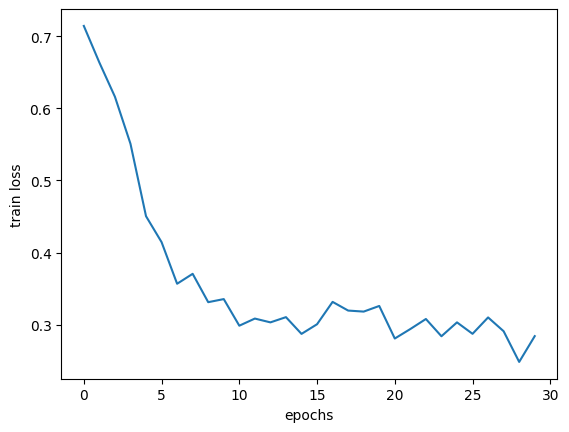

In [190]:
train_losses = []
for result in history_crop:
    train_losses.append(result["train_loss"])
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.show()

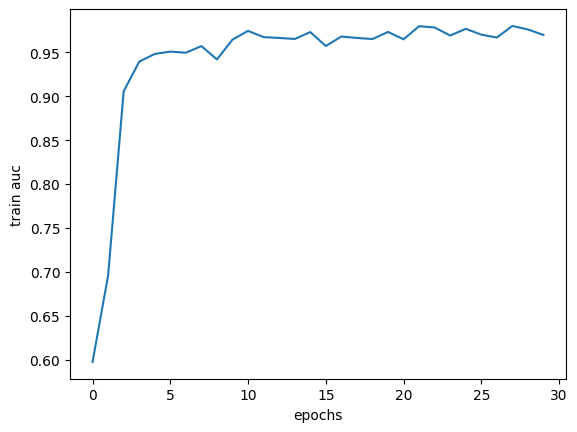

In [191]:
train_auc = []
for result in history_crop:
    train_auc.append(result["train_auc"])
plt.plot(train_auc)
plt.ylabel('train auc')
plt.xlabel('epochs')
plt.show()

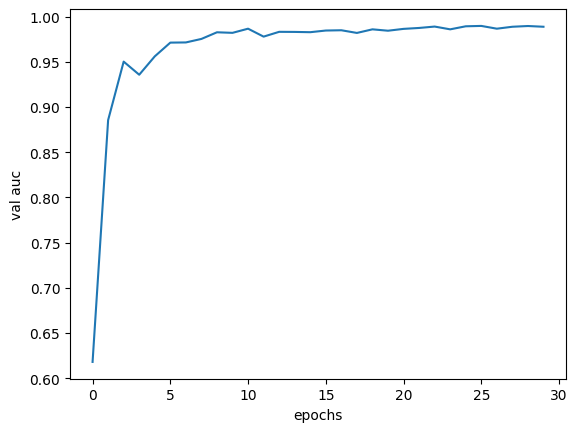

In [189]:
val_auc = []
for result in history_crop:
    val_auc.append(result["valid_auc"])
plt.plot(val_auc)
plt.ylabel('val auc')
plt.xlabel('epochs')
plt.show()

## Adding another conv layer to reduce size of the images

In [47]:
class CustomModelConv(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_first = nn.Conv2d(3, 12, 3, 2)
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
        self.model.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Sequential(
          nn.Linear(512, 256),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, num_classes)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.fc.parameters():
            param.requires_grad = True
        for param in self.conv_first.parameters():
            param.requires_grad = True
        for param in self.model.conv1.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.conv_first(xb)
        out = self.model(out)
        return out

In [48]:
train_dl = DataLoader(train_dataset_500, batch_size=8, sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_dataset_500, batch_size=8, sampler=valid_sampler, shuffle=False, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [135]:
lap_model = LaplacianModel(1000)

In [136]:
def testLaplacian(model, dl):
    labels = []
    results = []
    for data in tqdm(dl):
        images, targets = data
        for image in images:
            image = to_image(image)
            image = np.asarray(image)
            result = model(image)
            results.append(result)
        for label in targets:
            labels.append(label)
    acc, prec, rec = metrics(torch.Tensor(results), torch.Tensor(labels))
    f1 = 2 * (rec * prec) / (rec + prec)
    print(f'acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}')

In [137]:
testLaplacian(lap_model, train_dl)
testLaplacian(lap_model, valid_dl)

  0%|          | 0/105 [00:00<?, ?it/s]

acc: 0.7607, prec: 0.7390, rec: 0.9911, f1: 0.8467


  0%|          | 0/27 [00:00<?, ?it/s]

acc: 0.7238, prec: 0.7071, rec: 1.0000, f1: 0.8284


In [168]:
model = CustomModelConv(1).to(device)
model.freeze_model()
model.unfreeze_for_train()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


185809

In [170]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [171]:
writer.add_graph(model, images)
writer.close()

In [172]:
epochs = 30

In [174]:
max_lr = 0.0001
weight_decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
grad_clip = 1
torch.cuda.empty_cache()
scheduler = torch.optim.lr_scheduler.OneCycleLR
scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=int(len(train_dl)))
history_conv = []
for epoch in range(epochs):
    model.train()

    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    lrs = []
    for batch in tqdm(train_dl, f'training {epoch+1} epoch:'):
        loss, batch_acc, batch_prec, batch_rec = model.training_step(batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss)
        train_acc.append(batch_acc)
        train_prec.append(batch_prec)
        train_rec.append(batch_rec)
        lrs.append(get_lr(optimizer))
        scheduler.step()
        del batch
        torch.cuda.empty_cache()
    result = evaluate(model, valid_dl)
    result["train_loss"] = torch.stack(train_loss).mean().item()
    result["lrs"] = lrs
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_prec"] = torch.stack(train_prec).mean().item()
    result["train_rec"] = torch.stack(train_rec).mean().item()
    result["train_f1"] = 2 * (result["train_rec"] * result["train_prec"]) / (result["train_rec"] + result["train_prec"])
    result["train_auc"] = roc_metric(model, train_dl)
    result["valid_auc"] = roc_metric(model, valid_dl)
    history_conv.append(result)
    model.epoch_end(epoch,result)

training 1 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00001, train_loss: 0.7256, val_loss: 0.7100, train_acc: 0.3417, val_acc: 0.3380


training 2 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00002, train_loss: 0.6921, val_loss: 0.6695, train_acc: 0.5238, val_acc: 0.6759


training 3 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00003, train_loss: 0.6496, val_loss: 0.6407, train_acc: 0.6607, val_acc: 0.6481


training 4 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00004, train_loss: 0.6169, val_loss: 0.6163, train_acc: 0.6667, val_acc: 0.6620


training 5 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00006, train_loss: 0.5896, val_loss: 0.5715, train_acc: 0.6810, val_acc: 0.6759


training 6 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00008, train_loss: 0.5447, val_loss: 0.5656, train_acc: 0.7238, val_acc: 0.6713


training 7 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00009, train_loss: 0.4619, val_loss: 0.5018, train_acc: 0.8024, val_acc: 0.7037


training 8 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00010, train_loss: 0.3924, val_loss: 0.4039, train_acc: 0.8369, val_acc: 0.8519


training 9 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00010, train_loss: 0.3564, val_loss: 0.4129, train_acc: 0.8512, val_acc: 0.8056


training 10 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00010, train_loss: 0.3519, val_loss: 0.3712, train_acc: 0.8488, val_acc: 0.8565


training 11 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00010, train_loss: 0.3256, val_loss: 0.3662, train_acc: 0.8679, val_acc: 0.8565


training 12 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00010, train_loss: 0.3154, val_loss: 0.3785, train_acc: 0.8679, val_acc: 0.8472


training 13 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00009, train_loss: 0.2679, val_loss: 0.3332, train_acc: 0.8988, val_acc: 0.8426


training 14 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00009, train_loss: 0.2777, val_loss: 0.2423, train_acc: 0.8929, val_acc: 0.9259


training 15 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00008, train_loss: 0.2859, val_loss: 0.3284, train_acc: 0.8798, val_acc: 0.8565


training 16 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00008, train_loss: 0.2598, val_loss: 0.2667, train_acc: 0.8988, val_acc: 0.8796


training 17 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00007, train_loss: 0.2624, val_loss: 0.2613, train_acc: 0.8881, val_acc: 0.8843


training 18 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00006, train_loss: 0.2597, val_loss: 0.2061, train_acc: 0.8952, val_acc: 0.9120


training 19 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.2238, val_loss: 0.1811, train_acc: 0.9095, val_acc: 0.9398


training 20 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00005, train_loss: 0.2639, val_loss: 0.2186, train_acc: 0.8952, val_acc: 0.9120


training 21 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00004, train_loss: 0.2263, val_loss: 0.1845, train_acc: 0.9107, val_acc: 0.9120


training 22 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00003, train_loss: 0.2405, val_loss: 0.1490, train_acc: 0.9036, val_acc: 0.9444


training 23 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00003, train_loss: 0.2666, val_loss: 0.2280, train_acc: 0.8821, val_acc: 0.9028


training 24 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00002, train_loss: 0.2317, val_loss: 0.1573, train_acc: 0.9143, val_acc: 0.9444


training 25 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00001, train_loss: 0.2516, val_loss: 0.1615, train_acc: 0.9071, val_acc: 0.9444


training 26 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00001, train_loss: 0.2365, val_loss: 0.1817, train_acc: 0.9071, val_acc: 0.9398


training 27 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00000, train_loss: 0.2026, val_loss: 0.1635, train_acc: 0.9238, val_acc: 0.9306


training 28 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00000, train_loss: 0.1984, val_loss: 0.1600, train_acc: 0.9250, val_acc: 0.9352


training 29 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00000, train_loss: 0.2228, val_loss: 0.1874, train_acc: 0.9083, val_acc: 0.9213


training 30 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00000, train_loss: 0.2273, val_loss: 0.1777, train_acc: 0.9083, val_acc: 0.9306


In [175]:
for result in history_conv:
    print(result["train_acc"])

0.34166666865348816
0.523809552192688
0.660714328289032
0.6666666865348816
0.6809524297714233
0.723809540271759
0.8023809790611267
0.836904764175415
0.8511905074119568
0.848809540271759
0.8678571581840515
0.8678571581840515
0.898809552192688
0.8928571939468384
0.8797619342803955
0.898809552192688
0.8880952596664429
0.8952381014823914
0.9095238447189331
0.8952381014823914
0.910714328289032
0.9035714864730835
0.8821429014205933
0.9142857789993286
0.9071428775787354
0.9071428775787354
0.9238095879554749
0.925000011920929
0.9083333611488342
0.9083333611488342


In [176]:
for result in history_conv:
    print(result["val_acc"])

0.33796295523643494
0.6759259104728699
0.6481481790542603
0.6620370149612427
0.6759259104728699
0.6712962985038757
0.7037037014961243
0.8518518805503845
0.8055555820465088
0.8564814925193787
0.8564814925193787
0.8472222089767456
0.8425925970077515
0.9259259104728699
0.8564814925193787
0.8796296119689941
0.8842592835426331
0.9120370149612427
0.9398148059844971
0.9120370149612427
0.9120370149612427
0.944444477558136
0.9027777910232544
0.944444477558136
0.944444477558136
0.9398148059844971
0.9305555820465088
0.9351851940155029
0.9212962985038757
0.9305555820465088


In [177]:
for result in history_conv:
    print(result["train_prec"])

0.08571428805589676
0.6496825814247131
0.6672902703285217
0.6666666865348816
0.6797052621841431
0.7230952978134155
0.7995918393135071
0.8534921407699585
0.8865646719932556
0.8826984763145447
0.8895692229270935
0.8912925720214844
0.919070303440094
0.9195011854171753
0.910374104976654
0.9096599221229553
0.9248300194740295
0.9167574048042297
0.9296371936798096
0.919070303440094
0.9347618818283081
0.9248073101043701
0.9084126949310303
0.9248300194740295
0.9099093079566956
0.9262585043907166
0.9391156435012817
0.941111147403717
0.9259184002876282
0.9315873384475708


In [178]:
for result in history_conv:
    print(result["val_prec"])

0.03399471193552017
1.0
0.9629629850387573
1.0
1.0
1.0
1.0
0.9694443941116333
0.8700176477432251
1.0
0.8838623762130737
1.0
0.8774250149726868
0.9814814925193787
0.9259259104728699
0.9830247163772583
0.9925925731658936
0.9830247163772583
0.9876543879508972
1.0
0.9925925731658936
0.9682098627090454
1.0
0.9684743881225586
0.9833332896232605
0.9907407760620117
0.966005265712738
0.9709876775741577
0.9490740895271301
0.9854497909545898


In [179]:
for result in history_conv:
    print(result["train_rec"])

0.01843537576496601
0.4702834486961365
0.9801360964775085
1.0
0.9972789883613586
0.9714059233665466
0.9568140506744385
0.935102105140686
0.9199206829071045
0.9163265824317932
0.927108883857727
0.933741569519043
0.9401587843894958
0.9335487484931946
0.9241270422935486
0.9492404460906982
0.9207143783569336
0.9393650889396667
0.9476870894432068
0.9385828375816345
0.939795970916748
0.9436055421829224
0.928129255771637
0.9501814246177673
0.9567347764968872
0.9408164024353027
0.9561564326286316
0.9527891278266907
0.9449999928474426
0.9439002275466919


In [180]:
for result in history_conv:
    print(result["val_rec"])

0.18518519401550293
0.6759259104728699
0.6481481790542603
0.6620370149612427
0.6686508059501648
0.6686508059501648
0.6911376118659973
0.8409171104431152
0.8337742686271667
0.8234568238258362
0.8974426984786987
0.811640202999115
0.8863757252693176
0.9162257313728333
0.7984568476676941
0.8454144597053528
0.8560846447944641
0.8838624954223633
0.9146384596824646
0.8815696835517883
0.8809524178504944
0.9518077373504639
0.8808642029762268
0.9521163702011108
0.9342151284217834
0.9276455044746399
0.9365520477294922
0.9357143044471741
0.8864197731018066
0.9255732297897339


In [181]:
for result in history_conv:
    print(result["train_f1"])

0.030344315108974198
0.5456147003266767
0.7940085140742749
0.8000000143051146
0.8084223522485633
0.8290570070705774
0.8711661820549146
0.8924352735448652
0.9029347249220661
0.8991982342732938
0.9079511954286016
0.9120234040087677
0.9294949448746163
0.926471721215617
0.9171990219407554
0.9290288011472154
0.9227676098896568
0.9279235653924957
0.9385753694625164
0.9287240920179161
0.9372721668977769
0.9341118609813357
0.918165139824072
0.9373343380938732
0.9327347249866518
0.9334806982194441
0.9475594294086745
0.9469141338116924
0.9353618894973942
0.9377033649104652


In [182]:
for result in history_conv:
    print(result["val_f1"])

0.057444293051958084
0.8066297769546509
0.774797797203064
0.796657383441925
0.8014268279075623
0.8014268279075623
0.8173641562461853
0.900618314743042
0.8515104651451111
0.9031821489334106
0.8906007409095764
0.8960279822349548
0.8818776607513428
0.9477316737174988
0.857479989528656
0.9090412259101868
0.9192987084388733
0.9308100342750549
0.9497451782226562
0.9370577335357666
0.9334463477134705
0.9599387049674988
0.936659038066864
0.9602257013320923
0.9581451416015625
0.9581555724143982
0.9510506391525269
0.953024685382843
0.9166775941848755
0.9545734524726868


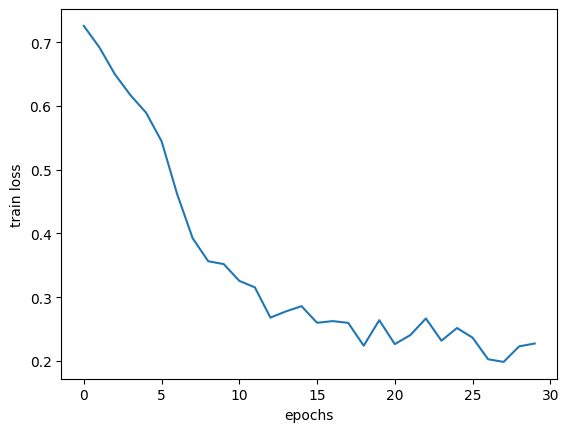

In [186]:
train_losses = []
for result in history_conv:
    train_losses.append(result["train_loss"])
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.show()

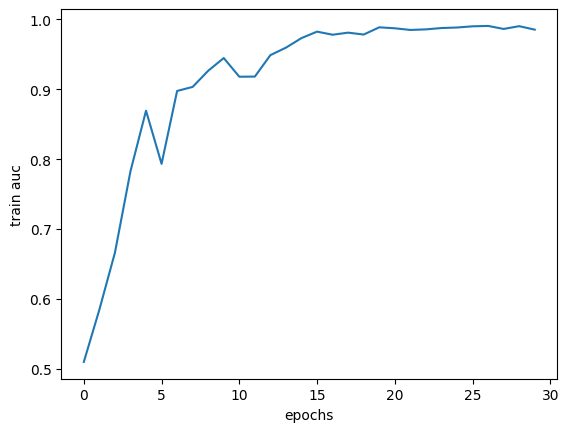

In [188]:
train_auc = []
for result in history_conv:
    train_auc.append(result["train_auc"])
plt.plot(train_auc)
plt.ylabel('train auc')
plt.xlabel('epochs')
plt.show()

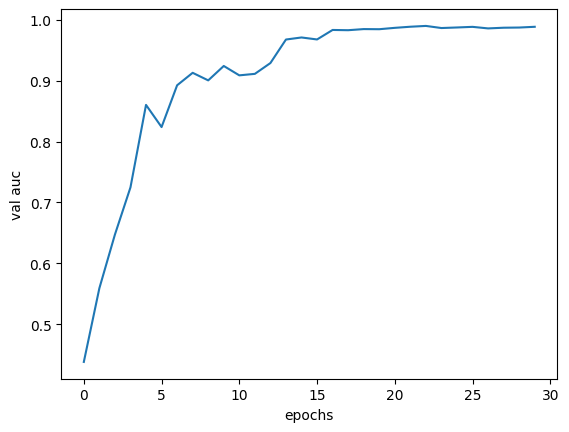

In [187]:
val_auc = []
for result in history_conv:
    val_auc.append(result["valid_auc"])
plt.plot(val_auc)
plt.ylabel('val auc')
plt.xlabel('epochs')
plt.show()

In [202]:
def find_max(history):
    maximum = 0
    for result in history:
        if result["valid_auc"] > maximum:
            maximum = result["valid_auc"]
    return maximum

In [203]:
max_500 = find_max(history_500)
max_256 = find_max(history_256)
max_crop = find_max(history_crop)
max_conv = find_max(history_conv)
print(f'500: {max_500:.4f}, 256: {max_256:.4f}, crop: {max_crop:.4f}, conv: {max_conv:.4f}')

500: 0.9706, 256: 0.8772, crop: 0.9896, conv: 0.9901


In [62]:
model = CustomModelConv(1).to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


21461073

In [63]:
epochs = 30

In [64]:
max_lr = 0.0001
weight_decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay = weight_decay)
grad_clip = 1
torch.cuda.empty_cache()
scheduler = torch.optim.lr_scheduler.OneCycleLR
scheduler = scheduler(optimizer,max_lr,epochs=epochs,steps_per_epoch=int(len(train_dl)))
history_tuned = []
for epoch in range(epochs):
    model.train()

    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    lrs = []
    for batch in tqdm(train_dl, f'training {epoch+1} epoch:'):
        loss, batch_acc, batch_prec, batch_rec = model.training_step(batch)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss)
        train_acc.append(batch_acc)
        train_prec.append(batch_prec)
        train_rec.append(batch_rec)
        lrs.append(get_lr(optimizer))
        scheduler.step()
        del batch
        torch.cuda.empty_cache()
    result = evaluate(model, valid_dl)
    result["train_loss"] = torch.stack(train_loss).mean().item()
    result["lrs"] = lrs
    result["train_acc"] = torch.stack(train_acc).mean().item()
    result["train_prec"] = torch.stack(train_prec).mean().item()
    result["train_rec"] = torch.stack(train_rec).mean().item()
    result["train_f1"] = 2 * (result["train_rec"] * result["train_prec"]) / (result["train_rec"] + result["train_prec"])
    result["train_auc"] = roc_metric(model, train_dl)
    result["valid_auc"] = roc_metric(model, valid_dl)
    history_tuned.append(result)
    model.epoch_end(epoch,result)

training 1 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00001, train_loss: 0.6719, val_loss: 0.6450, train_acc: 0.6274, val_acc: 0.6852


training 2 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00002, train_loss: 0.6022, val_loss: 0.5065, train_acc: 0.7345, val_acc: 0.7593


training 3 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00003, train_loss: 0.4248, val_loss: 0.3241, train_acc: 0.8440, val_acc: 0.8611


training 4 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00004, train_loss: 0.3078, val_loss: 0.2407, train_acc: 0.8786, val_acc: 0.9352


training 5 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00006, train_loss: 0.3086, val_loss: 0.2042, train_acc: 0.8690, val_acc: 0.9398


training 6 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00008, train_loss: 0.3023, val_loss: 0.2598, train_acc: 0.8679, val_acc: 0.8935


training 7 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00009, train_loss: 0.2472, val_loss: 0.1949, train_acc: 0.8988, val_acc: 0.9352


training 8 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00010, train_loss: 0.2313, val_loss: 0.1652, train_acc: 0.9131, val_acc: 0.9306


training 9 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00010, train_loss: 0.2407, val_loss: 0.1275, train_acc: 0.9071, val_acc: 0.9583


training 10 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00010, train_loss: 0.2589, val_loss: 0.2009, train_acc: 0.9071, val_acc: 0.9120


training 11 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00010, train_loss: 0.1689, val_loss: 0.3471, train_acc: 0.9357, val_acc: 0.8333


training 12 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00010, train_loss: 0.2291, val_loss: 0.1109, train_acc: 0.9048, val_acc: 0.9537


training 13 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00009, train_loss: 0.1522, val_loss: 0.2061, train_acc: 0.9464, val_acc: 0.9213


training 14 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00009, train_loss: 0.1684, val_loss: 0.1951, train_acc: 0.9405, val_acc: 0.9352


training 15 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00008, train_loss: 0.1835, val_loss: 0.2162, train_acc: 0.9357, val_acc: 0.9074


training 16 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00008, train_loss: 0.1458, val_loss: 0.1710, train_acc: 0.9571, val_acc: 0.9352


training 17 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00007, train_loss: 0.1395, val_loss: 0.1394, train_acc: 0.9524, val_acc: 0.9630


training 18 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00006, train_loss: 0.1235, val_loss: 0.2155, train_acc: 0.9560, val_acc: 0.9213


training 19 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.0977, val_loss: 0.1460, train_acc: 0.9643, val_acc: 0.9537


training 20 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00005, train_loss: 0.0674, val_loss: 0.1510, train_acc: 0.9774, val_acc: 0.9537


training 21 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00004, train_loss: 0.0810, val_loss: 0.0801, train_acc: 0.9738, val_acc: 0.9815


training 22 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00003, train_loss: 0.0654, val_loss: 0.0652, train_acc: 0.9726, val_acc: 0.9769


training 23 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00003, train_loss: 0.0453, val_loss: 0.0997, train_acc: 0.9833, val_acc: 0.9676


training 24 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00002, train_loss: 0.0384, val_loss: 0.0779, train_acc: 0.9905, val_acc: 0.9676


training 25 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00001, train_loss: 0.0314, val_loss: 0.1593, train_acc: 0.9929, val_acc: 0.9444


training 26 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00001, train_loss: 0.0174, val_loss: 0.0856, train_acc: 0.9964, val_acc: 0.9769


training 27 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00000, train_loss: 0.0199, val_loss: 0.0907, train_acc: 0.9940, val_acc: 0.9722


training 28 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00000, train_loss: 0.0160, val_loss: 0.0823, train_acc: 0.9964, val_acc: 0.9722


training 29 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00000, train_loss: 0.0114, val_loss: 0.0826, train_acc: 1.0000, val_acc: 0.9815


training 30 epoch::   0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00000, train_loss: 0.0102, val_loss: 0.0786, train_acc: 0.9988, val_acc: 0.9769


In [65]:
for result in history_tuned:
    print(result["train_acc"])

0.6273809671401978
0.7345238327980042
0.8440476655960083
0.8785714507102966
0.8690476417541504
0.8678571581840515
0.898809552192688
0.9130952954292297
0.9071428775787354
0.9071428775787354
0.9357143044471741
0.9047619104385376
0.9464285969734192
0.9404762387275696
0.9357143044471741
0.9571428894996643
0.9523810148239136
0.9559524059295654
0.9642857313156128
0.9773809909820557
0.973809540271759
0.9726190567016602
0.9833333492279053
0.9904762506484985
0.9928571581840515
0.9964286088943481
0.9940476417541504
0.9964286088943481
1.0
0.9988095760345459


In [66]:
for result in history_tuned:
    print(result["val_acc"])

0.6851851940155029
0.7592592835426331
0.8611111044883728
0.9351851940155029
0.9398148059844971
0.8935185074806213
0.9351851940155029
0.9305555820465088
0.9583333134651184
0.9120370149612427
0.8333333134651184
0.9537037014961243
0.9212962985038757
0.9351851940155029
0.9074074029922485
0.9351851940155029
0.9629629850387573
0.9212962985038757
0.9537037014961243
0.9537037014961243
0.9814814925193787
0.9768518805503845
0.9675925970077515
0.9675925970077515
0.944444477558136
0.9768518805503845
0.9722222089767456
0.9722222089767456
0.9814814925193787
0.9768518805503845


In [67]:
for result in history_tuned:
    print(result["train_prec"])

0.72931969165802
0.7498639822006226
0.862449049949646
0.9182313084602356
0.9066666960716248
0.9214286208152771
0.9251927137374878
0.9413832426071167
0.9361451268196106
0.930725634098053
0.9554648399353027
0.9312698841094971
0.9646711945533752
0.9600907564163208
0.949886679649353
0.9714966416358948
0.975623607635498
0.9668254852294922
0.9713379144668579
0.988548755645752
0.9745578169822693
0.9822675585746765
0.9833333492279053
0.9846031665802002
0.997619092464447
0.9980953335762024
0.9967347383499146
1.0
1.0
1.0


In [68]:
for result in history_tuned:
    print(result["val_prec"])

0.9753085970878601
0.9814814925193787
0.87328040599823
0.9753085970878601
0.9787036776542664
0.9208994507789612
0.9036154747009277
0.9202380776405334
0.9416225552558899
0.9873015880584717
1.0
0.9446649551391602
0.9003968238830566
0.9787036776542664
0.8969135880470276
0.9243385791778564
0.9894180297851562
0.9088624119758606
0.9783950448036194
0.9675484895706177
0.9798941612243652
0.9891974925994873
0.9938271045684814
0.9864197373390198
0.9938271045684814
0.9938271045684814
0.9947090148925781
0.9938271045684814
0.9907407760620117
0.9938271045684814


In [69]:
for result in history_tuned:
    print(result["train_rec"])

0.7141042947769165
0.933786928653717
0.9217233657836914
0.9071542024612427
0.914705216884613
0.9019274115562439
0.9325170516967773
0.9386281967163086
0.9345578551292419
0.9424943923950195
0.9549659490585327
0.9346258640289307
0.9597052931785583
0.9579024910926819
0.9603967666625977
0.9673696160316467
0.9640136361122131
0.9708050489425659
0.9732086658477783
0.9817006587982178
0.9883787035942078
0.9805329442024231
0.9890249967575073
0.9974490404129028
0.9931406378746033
0.9969048500061035
0.996258556842804
0.9958617091178894
1.0
0.997619092464447


In [70]:
for result in history_tuned:
    print(result["val_rec"])

0.6871693134307861
0.7410934567451477
0.8511905074119568
0.934303343296051
0.9358906149864197
0.934567928314209
0.9907407760620117
0.9678130745887756
0.9938271045684814
0.8972222208976746
0.7972663640975952
0.9864197373390198
0.9753085970878601
0.9340388178825378
0.9708995223045349
0.9709876775741577
0.9573192000389099
0.9783950448036194
0.9541445970535278
0.9686949253082275
0.9925925731658936
0.980158805847168
0.9613756537437439
0.9629629850387573
0.922927737236023
0.9746031761169434
0.9699735641479492
0.9695767164230347
0.9771605134010315
0.9746472239494324


In [71]:
for result in history_tuned:
    print(result["train_f1"])

0.7216317990733966
0.8317795337892863
0.8911015932390095
0.9126591454981918
0.9106682177020894
0.9115737312420049
0.9288404439906048
0.9400037009830755
0.9353508175828074
0.9365730438382731
0.9552153293566079
0.932944856054614
0.9621818365499811
0.9589953754432435
0.95511281071127
0.9694287364884321
0.9697838753151354
0.9688111804123658
0.97227239027897
0.9851128060814264
0.9814196043829818
0.9813994849104956
0.9861709607802381
0.9909844758154179
0.9953748277571223
0.997499736590401
0.9964965907098589
0.997926564318958
1.0
0.998808127362952


In [72]:
for result in history_tuned:
    print(result["val_f1"])

0.8062688708305359
0.8445141911506653
0.862093985080719
0.9543657302856445
0.9568184614181519
0.9276833534240723
0.9451746344566345
0.9434261918067932
0.9670208096504211
0.9401090145111084
0.8871988654136658
0.9650909304618835
0.936356782913208
0.9558497071266174
0.9324411749839783
0.9470890760421753
0.973103940486908
0.9423478245735168
0.9661176204681396
0.968121349811554
0.9862025380134583
0.9846574068069458
0.9773320555686951
0.974550187587738
0.9570661783218384
0.9841212630271912
0.9821855425834656
0.9815521836280823
0.9839038252830505
0.9841437339782715


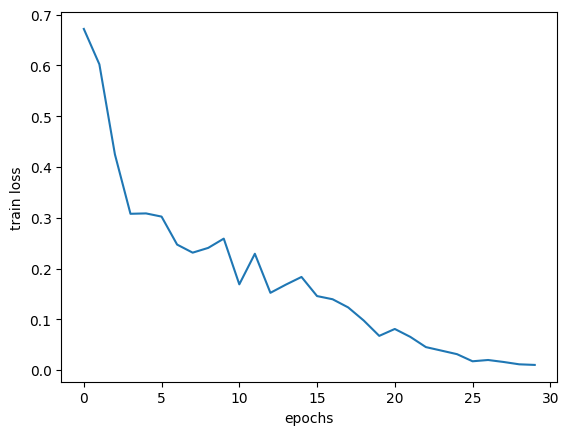

In [73]:
train_losses = []
for result in history_tuned:
    train_losses.append(result["train_loss"])
plt.plot(train_losses)
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.show()

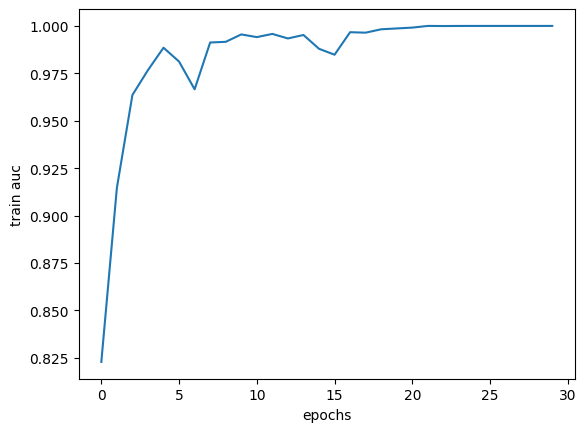

In [74]:
train_auc = []
for result in history_tuned:
    train_auc.append(result["train_auc"])
plt.plot(train_auc)
plt.ylabel('train auc')
plt.xlabel('epochs')
plt.show()

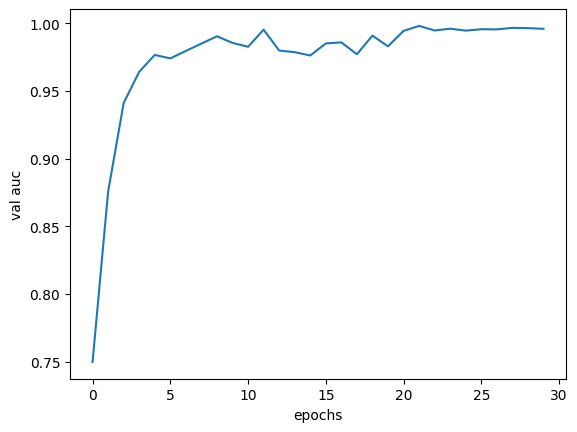

In [75]:
val_auc = []
for result in history_tuned:
    val_auc.append(result["valid_auc"])
plt.plot(val_auc)
plt.ylabel('val auc')
plt.xlabel('epochs')
plt.show()

In [76]:
torch.save(model.state_dict(), 'models/best_res.pt')

In [77]:
model.freeze_model()

In [219]:
!pip install brisque

     |████████████████████████████████| 135 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 170 kB 7.4 MB/s eta 0:00:01
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp38-cp38-linux_x86_64.whl size=253807 sha256=9906e30631b5f4473f535814670a9a13c3e7f2412dfb4e7e0f01e612e9378fd8
  Stored in directory: /home/berezerker/.cache/pip/wheels/41/00/e7/b328c0f5e4bbb9ac8ba5a72e56b1749be63dc1ab1c9321fd4e
Successfully built libsvm


In [78]:
from brisque import BRISQUE

In [82]:
method = BRISQUE()

In [83]:
model_conv = model.load_state_dict(torch.load('models/best_res.pt'))

In [84]:
all_y = []
all_brisque = []
all_labels = []
for batch in tqdm(valid_dl):
    brisques = []
    images, labels = batch
    out = model(images).squeeze(1)
    for image in images:
        score = method.score(to_image(image))
        all_brisque.append(score)
    all_labels = np.concatenate([all_labels, labels.detach().cpu().numpy()])
    all_y = np.concatenate([all_y, torch.sigmoid(out).detach().cpu().numpy()])

  0%|          | 0/27 [00:00<?, ?it/s]

In [85]:
all_labels

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1.])

In [86]:
values_valid = []
for i in range(len(all_y)):
    values = (all_y[i], all_brisque[i], all_labels[i])
    values_valid.append(values)
values_valid[:10]

[(0.9996823072433472, 43.74066354238764, 1.0),
 (0.009420093148946762, 28.40820371319134, 0.0),
 (0.999982476234436, 50.95379457232602, 1.0),
 (0.9999995231628418, 48.02019493996974, 1.0),
 (0.9998973608016968, 44.08681288303839, 1.0),
 (0.9985867738723755, -0.12973631119533025, 1.0),
 (0.9992830157279968, 52.768110615233326, 1.0),
 (0.9970507621765137, 27.779465272575152, 1.0),
 (0.9999943971633911, 36.2608118449061, 1.0),
 (0.22145001590251923, 32.53852546834818, 0.0)]

In [87]:
values_valid = sorted(values_valid,key=lambda x: x[0])

In [88]:
for i in range(len(all_y)):
    all_y[i] = values_valid[i][0]
for i in range(len(all_brisque)):
    all_brisque[i] = values_valid[i][1]
for i in range(len(all_labels)):
    all_labels[i] = values_valid[i][2]

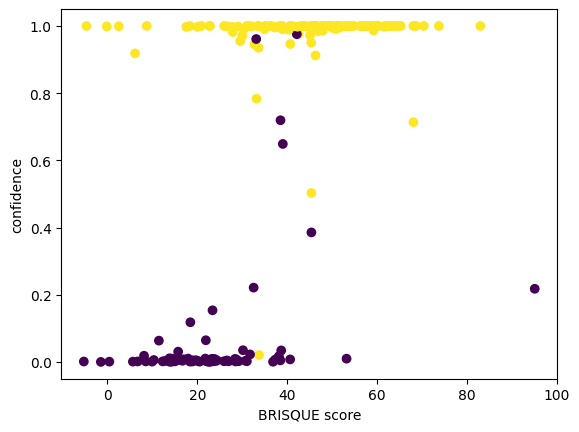

In [89]:
plt.scatter(all_brisque, all_y, c = all_labels)
plt.ylabel('confidence')
plt.xlabel('BRISQUE score')
plt.show()

In [ ]:
test_im_sharp = Image.open("data/test/test_1.jpg")
test_im_blurred = Image.open("data/test/blurred_test.jpg")

In [ ]:
test_im_sharp = valid_tfms(test_im_sharp)
test_im_blurred = valid_tfms(test_im_blurred)

In [ ]:
plt.imshow(test_im_sharp.permute(1,2,0))
plt.grid(None)

In [ ]:
plt.imshow(test_im_blurred.permute(1,2,0))
plt.grid(None)

In [ ]:
def test_predict(model, image):
    image = image.unsqueeze(0)
    pred = model(image)
    _, predicted = torch.max(pred, 1)
    print(predicted)

In [ ]:
test_im_sharp = test_im_sharp.to(device)
test_im_blurred = test_im_blurred.to(device)
test_predict(model, test_im_sharp)
test_predict(model, test_im_blurred)

In [ ]:
a = torch.tensor([0.6, 0.5])
a

In [ ]:
pred = torch.sigmoid(a)
pred